# Цель исследования

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. 

Цель работы - основе этих данных построить модель для определения стоимости автомобиля. 

Критерии, которые важны заказчику:

- качество предсказания;
- скорость предсказания;
- время обучения.

План работы:

- предобработка данных
- исследовательский анализ
- корреляционный анализ
- подготовка данных
- обучение моделей
- общий вывод


In [1]:
%pip install phik -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
%pip install shap -q

Note: you may need to restart the kernel to use updated packages.


In [3]:
!pip install -U scikit-learn -q

In [4]:
%pip install lightgbm -q

Note: you may need to restart the kernel to use updated packages.


In [5]:
%pip install optuna -q

Note: you may need to restart the kernel to use updated packages.


In [6]:
%pip install category_encoders -q

Note: you may need to restart the kernel to use updated packages.


In [7]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import numpy as np
import phik
import shap
import time


from sklearn.model_selection import (
    train_test_split,
    GridSearchCV,
    RandomizedSearchCV
)

from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from lightgbm import LGBMRegressor
from optuna.integration import OptunaSearchCV
from category_encoders import BinaryEncoder


from sklearn.impute import SimpleImputer

from sklearn.preprocessing import (
    OneHotEncoder,
    StandardScaler,
    OrdinalEncoder,
    MinMaxScaler,
    RobustScaler
)
from sklearn.metrics import (
    mean_squared_error,
    r2_score,
    mean_absolute_error,
    confusion_matrix,
    precision_score,
    recall_score,
    accuracy_score,
    roc_auc_score,
    make_scorer,
    root_mean_squared_error
)

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

RANDOM_STATE = 42
TEST_SIZE = 0.25

## Подготовка данных

### Загрузка данных

In [8]:
def load_csv(file_name):
    try:
        return pd.read_csv(f'/datasets/{file_name}', sep=',')
    except:
        return pd.read_csv(
            f'https://code.s3.yandex.net/datasets/{file_name}', sep=',')

In [9]:
data = load_csv('autos.csv')

In [10]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

В данных присутствуют пропуски, по некоторым столбцам потребуется изменить тип данных.

### Предобработка данных

#### Названия столбцов

In [12]:
data.columns

Index(['DateCrawled', 'Price', 'VehicleType', 'RegistrationYear', 'Gearbox',
       'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired', 'DateCreated', 'NumberOfPictures', 'PostalCode',
       'LastSeen'],
      dtype='object')

Переименуем столбцы

In [13]:
data.rename(columns={'DateCrawled': 'date_crawled', 'Price': 'price', 'VehicleType': 'vehicle_type', \
                     'RegistrationYear': 'registration_year', 'Gearbox': 'gearbox', 'Power': 'power', \
                     'Model': 'model', 'Kilometer': 'kilometer', 'RegistrationMonth': 'registration_month', \
                     'FuelType': 'fuel_type', 'Brand': 'brand', 'Repaired': 'repaired', \
                     'DateCreated': 'date_created', 'NumberOfPictures': 'number_of_pictures', \
                     'PostalCode': 'postal_code', 'LastSeen': 'last_seen'}, inplace=True)

In [14]:
data.head(5)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


#### Типы данных

In [15]:
data.dtypes

date_crawled          object
price                  int64
vehicle_type          object
registration_year      int64
gearbox               object
power                  int64
model                 object
kilometer              int64
registration_month     int64
fuel_type             object
brand                 object
repaired              object
date_created          object
number_of_pictures     int64
postal_code            int64
last_seen             object
dtype: object

Изменим тип данных с датами

In [16]:
data['date_crawled'] = data['date_crawled'].astype('datetime64[ns]')

In [17]:
data['date_created'] = data['date_created'].astype('datetime64[ns]')

In [18]:
data['last_seen'] = data['last_seen'].astype('datetime64[ns]')

In [19]:
data.dtypes

date_crawled          datetime64[ns]
price                          int64
vehicle_type                  object
registration_year              int64
gearbox                       object
power                          int64
model                         object
kilometer                      int64
registration_month             int64
fuel_type                     object
brand                         object
repaired                      object
date_created          datetime64[ns]
number_of_pictures             int64
postal_code                    int64
last_seen             datetime64[ns]
dtype: object

#### Пропуски данных

In [20]:
data.isna().sum()

date_crawled              0
price                     0
vehicle_type          37490
registration_year         0
gearbox               19833
power                     0
model                 19705
kilometer                 0
registration_month        0
fuel_type             32895
brand                     0
repaired              71154
date_created              0
number_of_pictures        0
postal_code               0
last_seen                 0
dtype: int64

Удалим записи с отсутствующими данными о модели автомобиля.

In [21]:
ind_drop_model = data.query('model.isna() == True').index

In [22]:
clear_data = data.drop(ind_drop_model)

Пропуски в типе транспортного средства, коробки передач и типе топлива заполним модой по бренду и модели.

In [23]:
for column in ['vehicle_type', 'gearbox', 'fuel_type']:
    for brand in clear_data['brand'].unique():
        for model in clear_data.query('brand == @brand')['model'].unique():
            clear_data.loc[(clear_data[column].isna())&\
                           (clear_data['brand'] == brand)&\
                           (clear_data['model'] == model), column] = \
            clear_data.loc[(clear_data['brand'] == brand)&\
                           (clear_data['model'] == model), column].mode()[0]

Пропуски в столбце с информацией о ремонте заменим на значение `no`.

In [24]:
clear_data['repaired'] = clear_data['repaired'].fillna('no')

In [25]:
clear_data.isna().sum()

date_crawled          0
price                 0
vehicle_type          0
registration_year     0
gearbox               0
power                 0
model                 0
kilometer             0
registration_month    0
fuel_type             0
brand                 0
repaired              0
date_created          0
number_of_pictures    0
postal_code           0
last_seen             0
dtype: int64

#### Проверка на наличие дубликатов

In [26]:
clear_data.duplicated().sum()

5

Удалим дубликаты.

In [27]:
clear_data.drop_duplicates(inplace=True)

#### Проверка на ошибки

In [28]:
for col_name, col_data in clear_data.items():
    if col_data.dtype == 'object':
        print(col_name, sorted(clear_data[col_name].unique()), '\n')

vehicle_type ['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv', 'wagon'] 

gearbox ['auto', 'manual'] 

model ['100', '145', '147', '156', '159', '1_reihe', '1er', '200', '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe', '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900', '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8', 'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea', 'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo', 'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora', 'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse', 'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma', 'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee', 'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo', 'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma', 'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery', 'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'e

In [29]:
for brand in clear_data['brand'].unique():
    print(brand, sorted(clear_data.query('brand == @brand')['model'].unique()), '\n')

volkswagen ['amarok', 'beetle', 'bora', 'caddy', 'cc', 'eos', 'fox', 'golf', 'jetta', 'kaefer', 'lupo', 'other', 'passat', 'phaeton', 'polo', 'scirocco', 'sharan', 'tiguan', 'touareg', 'touran', 'transporter', 'up'] 

jeep ['cherokee', 'grand', 'other', 'wrangler'] 

skoda ['citigo', 'fabia', 'octavia', 'other', 'roomster', 'superb', 'yeti'] 

bmw ['1er', '3er', '5er', '6er', '7er', 'i3', 'm_reihe', 'other', 'x_reihe', 'z_reihe'] 

peugeot ['1_reihe', '2_reihe', '3_reihe', '4_reihe', '5_reihe', 'other'] 

ford ['b_max', 'c_max', 'escort', 'fiesta', 'focus', 'fusion', 'galaxy', 'ka', 'kuga', 'mondeo', 'mustang', 'other', 's_max', 'transit'] 

mazda ['1_reihe', '3_reihe', '5_reihe', '6_reihe', 'cx_reihe', 'mx_reihe', 'other', 'rx_reihe'] 

nissan ['almera', 'juke', 'micra', 'navara', 'note', 'other', 'primera', 'qashqai', 'x_trail'] 

renault ['clio', 'espace', 'kangoo', 'laguna', 'megane', 'modus', 'other', 'r19', 'scenic', 'twingo'] 

mercedes_benz ['a_klasse', 'b_klasse', 'c_klasse', 

В столбце с типом топлива заменим значение `gasoline` на `petrol`, т.к. данные термины обозначают один и тот же вид топлива

In [30]:
clear_data['fuel_type'] = clear_data['fuel_type'].replace('gasoline', 'petrol')

### Исследовательский анализ данных

**Дата скачивания анкеты**

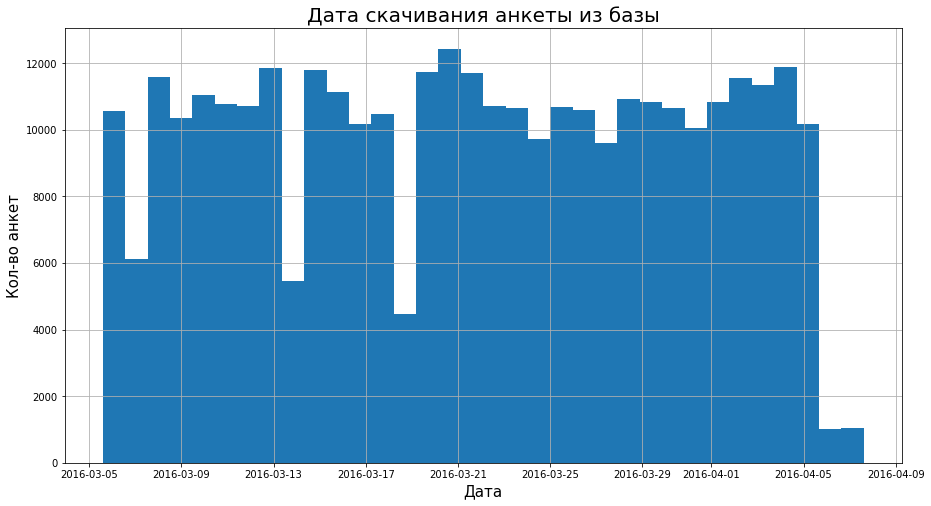

In [31]:
clear_data['date_crawled'].hist(bins=34, figsize=(15,8))
plt.title('Дата скачивания анкеты из базы', fontsize=20)
plt.ylabel('Кол-во анкет', fontsize=15)
plt.xlabel('Дата', fontsize=15)
plt.show()

**Цена**

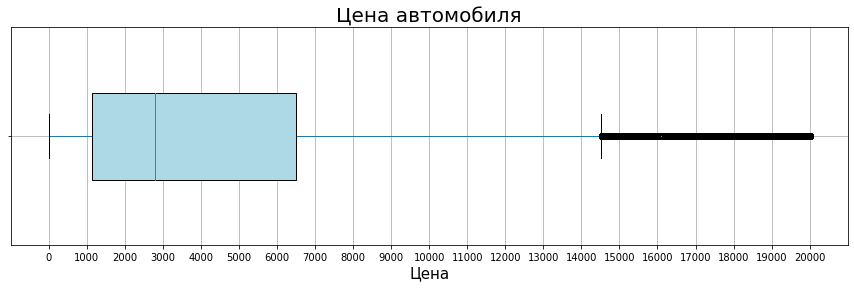

In [32]:
clear_data.boxplot(column=['price'], figsize=(15, 4), vert=False, patch_artist=True, \
        boxprops=dict(facecolor='lightblue'), widths=0.4).set_yticklabels([])
plt.grid(True)
plt.title('Цена автомобиля', fontsize=20)
plt.ylabel('')
plt.xlabel('Цена', fontsize=15)
plt.xticks(range(0, 21000, 1000))
plt.show()

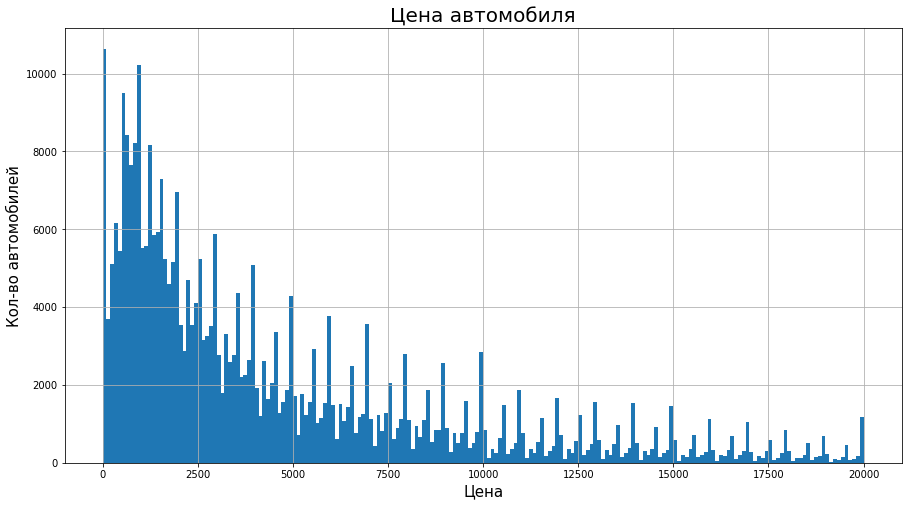

In [33]:
clear_data['price'].hist(bins=200, figsize=(15,8))
plt.title('Цена автомобиля', fontsize=20)
plt.ylabel('Кол-во автомобилей', fontsize=15)
plt.xlabel('Цена', fontsize=15)
plt.show()

In [34]:
clear_data['price'].quantile([0.04, 0.99])

0.04      150.0
0.99    18800.0
Name: price, dtype: float64

Удалим записи со значениями стоимости менее 100 как аномальные.

In [36]:
ind_drop_price = clear_data.query('price < 100').index

In [37]:
clear_data.drop(ind_drop_price, inplace=True)

**Тип кузова**

In [38]:
pivot_vehicle_type = clear_data.pivot_table(index='vehicle_type', values='price', aggfunc='count')

In [39]:
pivot_vehicle_type['percent'] = \
(pivot_vehicle_type['price'] / pivot_vehicle_type['price'].sum()).round(3)*100

In [40]:
pivot_vehicle_type

,price,percent
vehicle_type,,
bus,30772,9.5
convertible,19224,5.9
coupe,15213,4.7
other,2650,0.8
sedan,97298,30.0
small,82639,25.5
suv,11621,3.6
wagon,64600,19.9


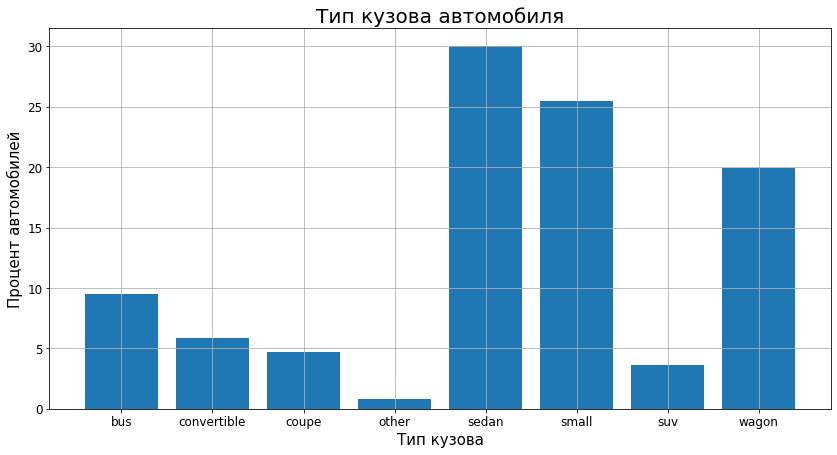

In [41]:
plt.figure(figsize=(14,7))
X_axis = np.arange(pivot_vehicle_type['percent'].nunique())
plt.bar(X_axis, pivot_vehicle_type['percent'])
plt.xticks(X_axis, pivot_vehicle_type.index)
plt.title('Тип кузова автомобиля', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Процент автомобилей', fontsize=15)
plt.xlabel('Тип кузова', fontsize=15)
plt.grid()
plt.show()

Наиболее встречающиеся типы кузовов - sedan, small, wagon.

**Год регистрации автомобиля**

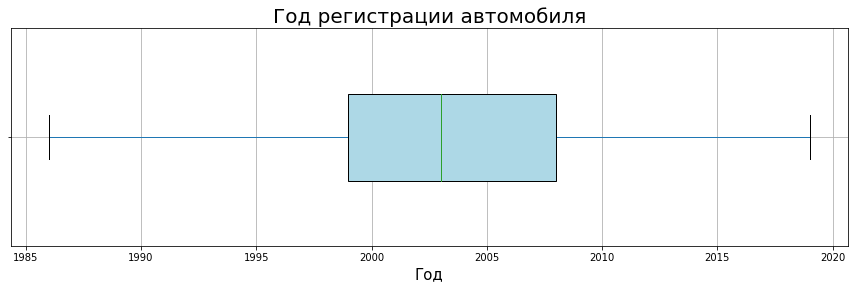

In [42]:
clear_data.boxplot(column=['registration_year'], figsize=(15, 4), vert=False, patch_artist=True, \
        boxprops=dict(facecolor='lightblue'), widths=0.4, showfliers=False).set_yticklabels([])
plt.grid(True)
plt.title('Год регистрации автомобиля', fontsize=20)
plt.ylabel('')
plt.xlabel('Год', fontsize=15)
plt.xticks(range(1985, 2024, 5))
plt.show()

In [43]:
sorted(clear_data['registration_year'].unique())

[1000,
 1001,
 1234,
 1300,
 1400,
 1500,
 1600,
 1602,
 1800,
 1910,
 1923,
 1927,
 1928,
 1929,
 1930,
 1931,
 1932,
 1933,
 1934,
 1935,
 1936,
 1937,
 1938,
 1941,
 1942,
 1943,
 1945,
 1947,
 1949,
 1950,
 1951,
 1952,
 1953,
 1954,
 1955,
 1956,
 1957,
 1958,
 1959,
 1960,
 1961,
 1962,
 1963,
 1964,
 1965,
 1966,
 1967,
 1968,
 1969,
 1970,
 1971,
 1972,
 1973,
 1974,
 1975,
 1976,
 1977,
 1978,
 1979,
 1980,
 1981,
 1982,
 1983,
 1984,
 1985,
 1986,
 1987,
 1988,
 1989,
 1990,
 1991,
 1992,
 1993,
 1994,
 1995,
 1996,
 1997,
 1998,
 1999,
 2000,
 2001,
 2002,
 2003,
 2004,
 2005,
 2006,
 2007,
 2008,
 2009,
 2010,
 2011,
 2012,
 2013,
 2014,
 2015,
 2016,
 2017,
 2018,
 2019,
 2066,
 2200,
 2290,
 2500,
 2900,
 3000,
 3700,
 4000,
 4500,
 5000,
 5555,
 5900,
 5911,
 6000,
 7000,
 7100,
 7800,
 8200,
 8500,
 9000,
 9999]

In [44]:
clear_data.query('registration_year < 1985 or registration_year > 2019')['price'].count()

3928

In [45]:
clear_data['date_crawled'].min()

Timestamp('2016-03-05 14:06:22')

In [46]:
clear_data['date_crawled'].max()

Timestamp('2016-04-07 14:36:58')

Удалим записи с годом регистрации менее 1985 и более 2016, т.к. все анкеты были выгружены в 2016 году.

In [48]:
ind_drop_year = clear_data.query('registration_year < 1985 or registration_year > 2016').index

In [49]:
clear_data.drop(ind_drop_year, inplace=True)

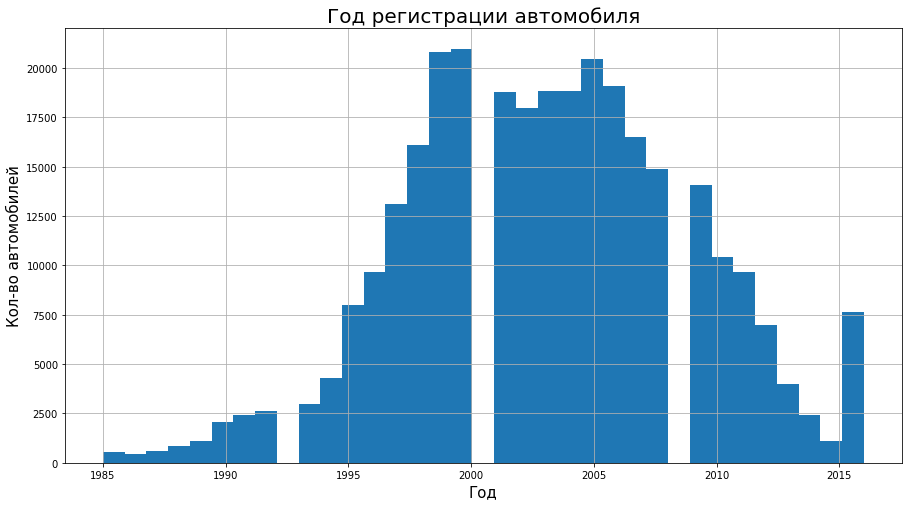

In [50]:
clear_data['registration_year'].hist(bins=35, figsize=(15,8))
plt.title('Год регистрации автомобиля', fontsize=20)
plt.ylabel('Кол-во автомобилей', fontsize=15)
plt.xlabel('Год', fontsize=15)
plt.show()

In [51]:
clear_data['registration_year'].describe().round()

count    308289.0
mean       2003.0
std           6.0
min        1985.0
25%        1999.0
50%        2003.0
75%        2007.0
max        2016.0
Name: registration_year, dtype: float64

Медианное значение года регистрации - 2003, межквартильный интервал - от 1999 до 2007.

**Коробка передач**

In [52]:
pivot_gearbox = clear_data.pivot_table(index='gearbox', values='price', aggfunc='count')

In [53]:
pivot_gearbox['percent'] = \
(pivot_gearbox['price'] / pivot_gearbox['price'].sum()).round(3)*100

In [54]:
pivot_gearbox

,price,percent
gearbox,,
auto,60800,19.7
manual,247489,80.3


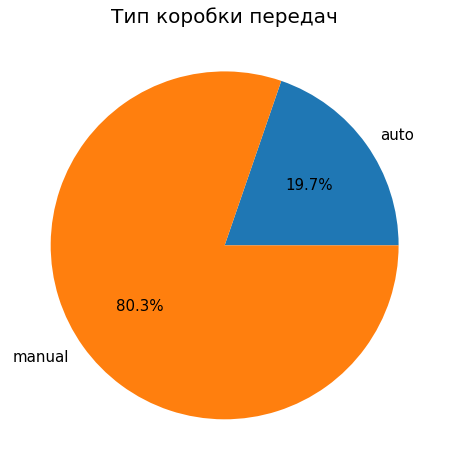

In [55]:
pivot_gearbox['price'].plot(kind='pie', figsize=(8, 8), fontsize=15, autopct='%1.1f%%')
plt.title('Тип коробки передач', fontsize=20)
plt.ylabel('');

Абсолютное большинство автомобилей оснащены механической коробкой передач.

**Мощность**

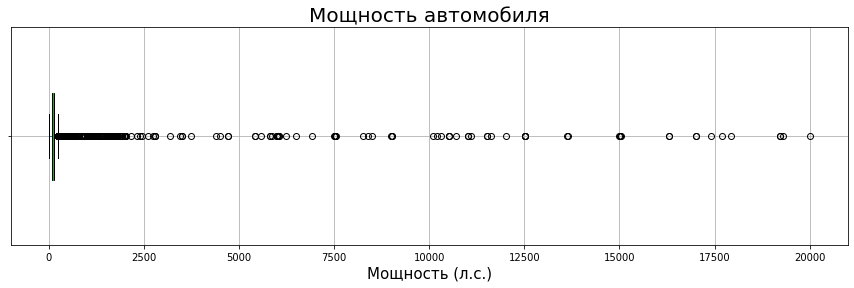

In [56]:
clear_data.boxplot(column=['power'], figsize=(15, 4), vert=False, patch_artist=True, \
        boxprops=dict(facecolor='lightblue'), widths=0.4).set_yticklabels([])
plt.grid(True)
plt.title('Мощность автомобиля', fontsize=20)
plt.ylabel('')
plt.xlabel('Мощность (л.с.)', fontsize=15)
plt.show()

In [57]:
clear_data.query('power == 0')['price'].count()

26707

Присутствует много записей с нулевой мощностью автомобиля. По данным записям заменим нулевое значение на модальное значение по марке и модели.

In [58]:
for brand in clear_data['brand'].unique():
    for model in clear_data.query('brand == @brand')['model'].unique():
        clear_data.loc[(clear_data['power'] == 0)&\
                        (clear_data['brand'] == brand)&\
                        (clear_data['model'] == model), 'power'] = \
        clear_data.loc[(clear_data['brand'] == brand)&\
                       (clear_data['model'] == model), 'power'].mode()[0]

In [59]:
clear_data['power'].quantile([0.01, 0.99])

0.01     41.0
0.99    300.0
Name: power, dtype: float64

Удалим записи с мощнотью менее 40 и более 600 л.с.

In [61]:
ind_drop_power = clear_data.query('power < 40 or power > 600').index

In [62]:
clear_data.drop(ind_drop_power, inplace=True)

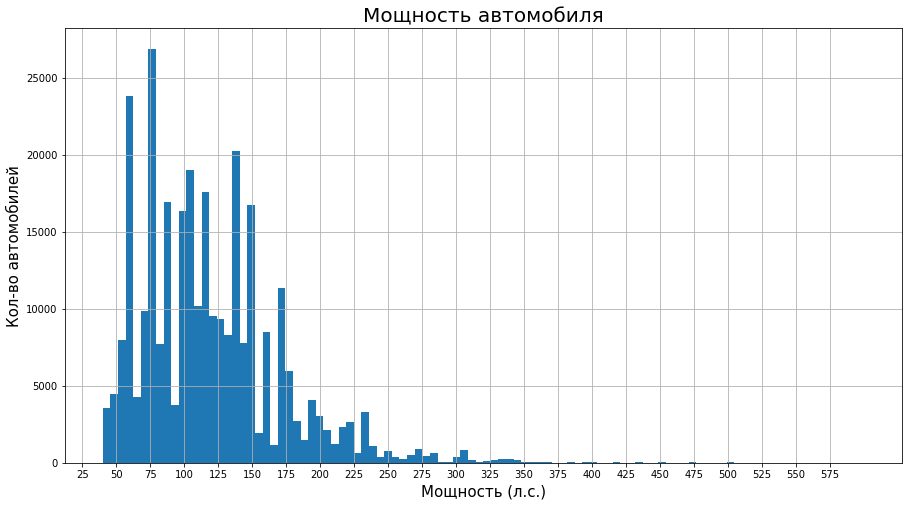

In [63]:
clear_data['power'].hist(bins=100, figsize=(15,8))
plt.title('Мощность автомобиля', fontsize=20)
plt.ylabel('Кол-во автомобилей', fontsize=15)
plt.xlabel('Мощность (л.с.)', fontsize=15)
plt.xticks(range(25, 600, 25))
plt.show()

In [64]:
clear_data['power'].describe().round()

count    305386.0
mean        120.0
std          53.0
min          40.0
25%          75.0
50%         110.0
75%         150.0
max         600.0
Name: power, dtype: float64

Среднее значение мощности автомобилей - 120 л.с., медиана - 110. Межквартильный интервал от 75 до 150 л.с.

**Пробег**

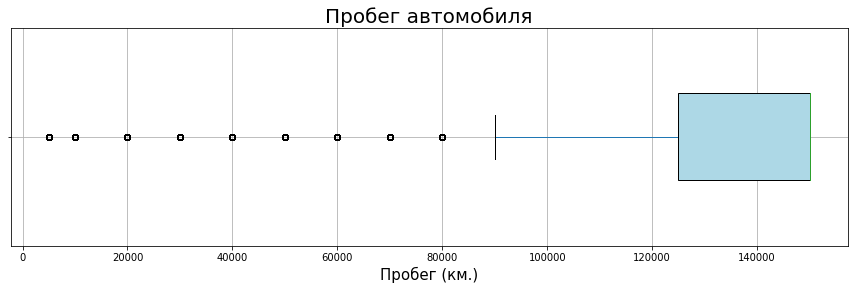

In [65]:
clear_data.boxplot(column=['kilometer'], figsize=(15, 4), vert=False, patch_artist=True, \
        boxprops=dict(facecolor='lightblue'), widths=0.4).set_yticklabels([])
plt.grid(True)
plt.title('Пробег автомобиля', fontsize=20)
plt.ylabel('')
plt.xlabel('Пробег (км.)', fontsize=15)
plt.show()

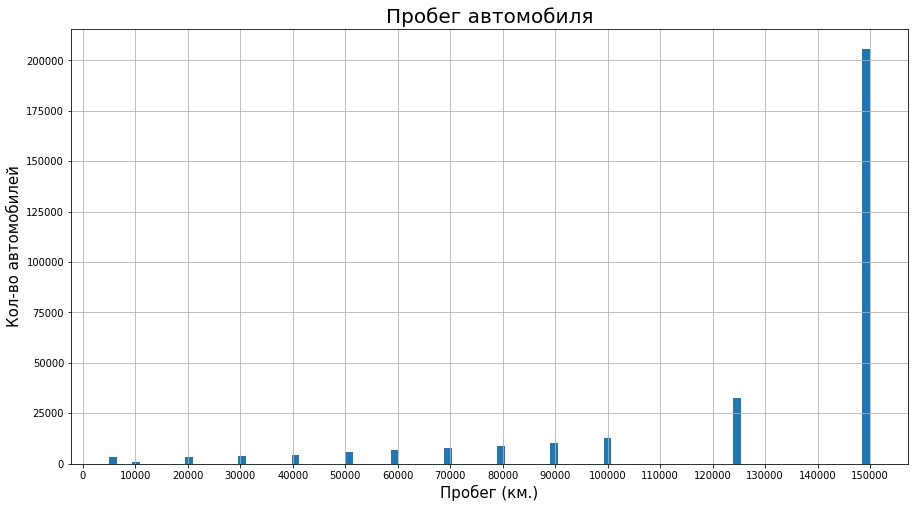

In [66]:
clear_data['kilometer'].hist(bins=100, figsize=(15,8))
plt.title('Пробег автомобиля', fontsize=20)
plt.ylabel('Кол-во автомобилей', fontsize=15)
plt.xlabel('Пробег (км.)', fontsize=15)
plt.xticks(range(0, 160000, 10000))
plt.show()

Данные о пробеге представлены ограниченным числом значений. Подавляющее большинство автомобилей имеет пробег 150000 км. Удалять данные не будем т.к. у автомобиля может быть небольшой пробег.

**Месяц регистрации**

In [67]:
pivot_month = clear_data.pivot_table(index='registration_month', values='price', aggfunc='count')

In [68]:
pivot_month['percent'] = \
(pivot_month['price'] / pivot_month['price'].sum()).round(3)*100

In [69]:
pivot_month

,price,percent
registration_month,,
0,22528,7.4
1,20386,6.7
2,18966,6.2
3,30837,10.1
4,25926,8.5
5,25869,8.5
6,27946,9.2
7,24026,7.9
8,20197,6.6


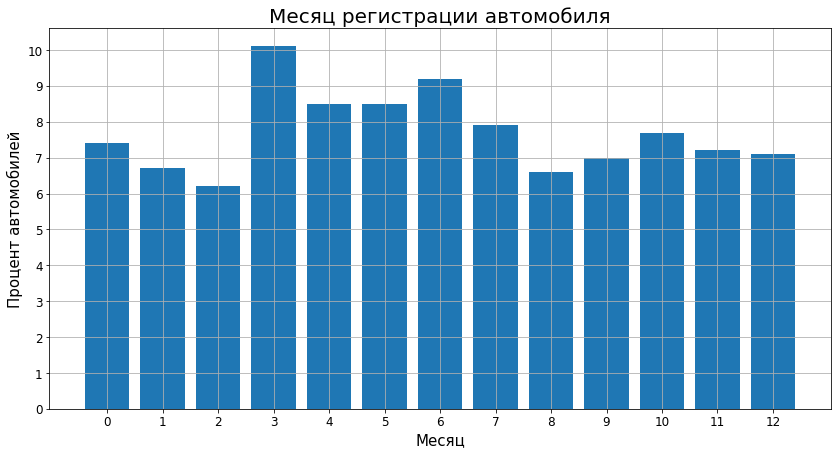

In [70]:
plt.figure(figsize=(14,7))
plt.bar(pivot_month.index, pivot_month['percent'])
plt.title('Месяц регистрации автомобиля', fontsize=20)
plt.xticks(range(0, 13, 1), fontsize=12)
plt.yticks(range(0, 11, 1), fontsize=12)
plt.ylabel('Процент автомобилей', fontsize=15)
plt.xlabel('Месяц', fontsize=15)
plt.grid()
plt.show()

Наибольший процент автомобилей был зарегистрирован в 3-м месяце. Также в данных присутствует нулевой месяц. Видимо у данных автомобилей месяц указан не был.

Удалим данный признак т.к. он распределен практичекски равномерно не несет в себе информативности.

In [71]:
clear_data.drop(columns=['registration_month'], inplace=True)

**Тип топлива**

In [72]:
pivot_fuel = clear_data.pivot_table(index='fuel_type', values='price', aggfunc='count')

In [73]:
pivot_fuel['percent'] = \
(pivot_fuel['price'] / pivot_fuel['price'].sum()).round(4)*100

In [74]:
pivot_fuel

,price,percent
fuel_type,,
cng,504,0.17
electric,34,0.01
hybrid,196,0.06
lpg,4637,1.52
other,61,0.02
petrol,299954,98.22


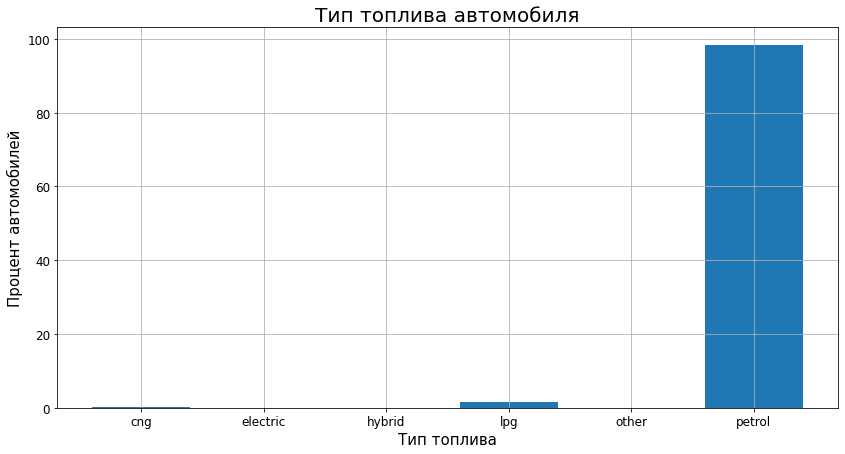

In [75]:
plt.figure(figsize=(14,7))
plt.bar(pivot_fuel.index, pivot_fuel['percent'])
plt.title('Тип топлива автомобиля', fontsize=20)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylabel('Процент автомобилей', fontsize=15)
plt.xlabel('Тип топлива', fontsize=15)
plt.grid()
plt.show()

Абсолютное большинтво автомобилей с бензиновыми двигателями.

**Бренд**

In [76]:
pivot_brand = clear_data.pivot_table(index='brand', values='price', aggfunc='count')

In [77]:
pivot_brand['percent'] = \
(pivot_brand['price'] / pivot_brand['price'].sum()).round(4)*100

In [78]:
pivot_brand.sort_values(by='percent', ascending=False).head(10)

,price,percent
brand,,
volkswagen,66522,21.78
opel,34418,11.27
bmw,32796,10.74
mercedes_benz,28228,9.24
audi,26449,8.66
ford,22094,7.23
renault,15162,4.96
peugeot,9450,3.09
fiat,7785,2.55


В тройку самых популярных брендов входят volkswagen, opel, bmw.

**Ремонт**

In [79]:
pivot_repaired = clear_data.pivot_table(index='repaired', values='price', aggfunc='count')

In [80]:
pivot_repaired['percent'] = \
(pivot_repaired['price'] / pivot_repaired['price'].sum()).round(4)*100

In [81]:
pivot_repaired

,price,percent
repaired,,
no,275662,90.27
yes,29724,9.73


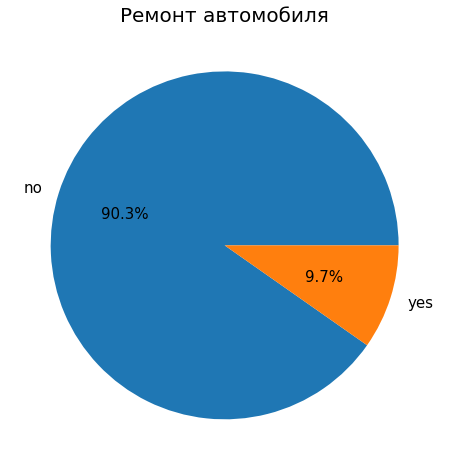

In [82]:
pivot_repaired['price'].plot(kind='pie', figsize=(8, 8), fontsize=15, autopct='%1.1f%%')
plt.title('Ремонт автомобиля', fontsize=20)
plt.ylabel('');

В 90% случаях ремонт не производился.

**Количество фотографий**

In [83]:
clear_data['number_of_pictures'].unique()

array([0])

В данном столбце у всех записей значение 0. Удалим данный столбец.

In [84]:
clear_data.drop(columns=['number_of_pictures'], inplace=True)

**Неинформативные столбцы**

Удалим следующие столбцы как неинформативные: date_crawled, date_created, postal_code, last_seen.

In [85]:
clear_data.drop(columns=['date_crawled', 'date_created', 'postal_code', 'last_seen'], inplace=True)

In [86]:
clear_data.head()

,price,vehicle_type,registration_year,gearbox,power,model,kilometer,fuel_type,brand,repaired
0,480,sedan,1993,manual,75,golf,150000,petrol,volkswagen,no
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,no
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


### Корреляционный анализ

overflow encountered in long_scalars


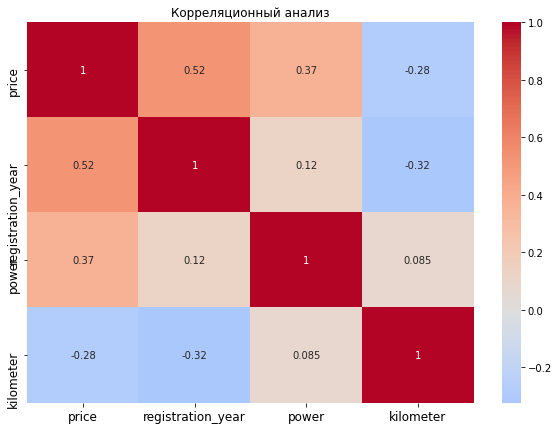

In [87]:
plt.subplots(figsize=(10, 7))
sns.heatmap(clear_data.corr(method='kendall'), annot=True, cmap='coolwarm', center=0,)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.title('Корреляционный анализ')
plt.show()

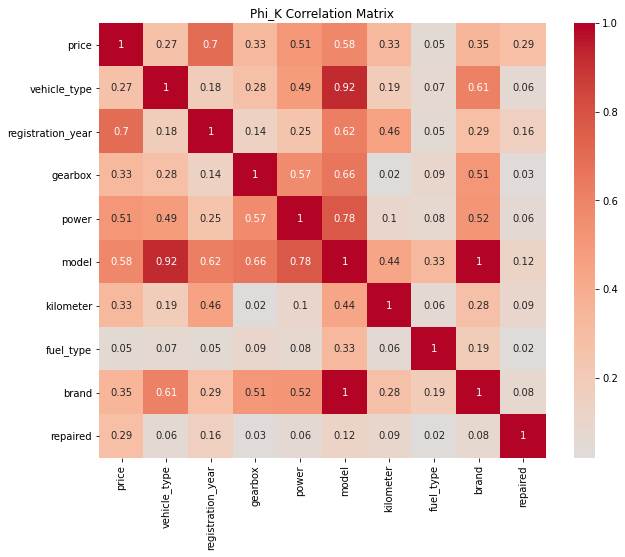

In [88]:
plt.figure(figsize=(10, 8))
sns.heatmap(clear_data.phik_matrix(interval_cols=['power', 'price', 'registration_year'])
            .round(2), cmap='coolwarm', center=0, annot=True)
plt.title('Phi_K Correlation Matrix')
plt.show()

Среди признаков наибольшая зависимость с ценой наблюдается у года регистрации, модели и мощности.

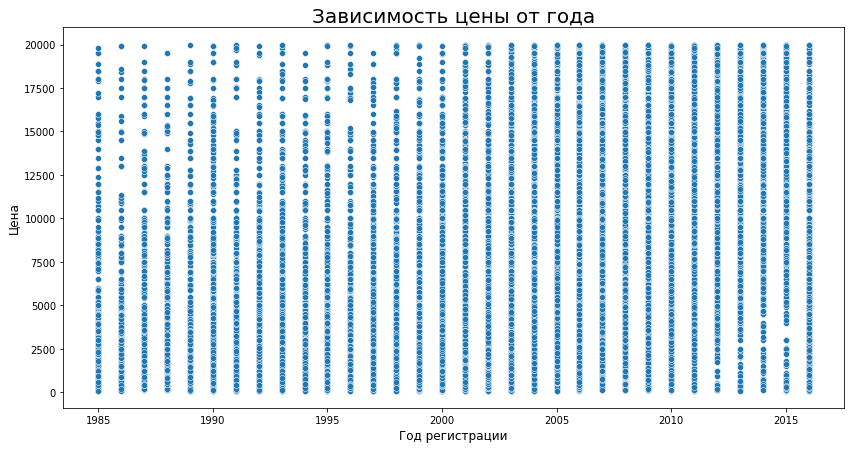

In [89]:
plt.figure(figsize=(14,7))
sns.scatterplot(data=clear_data, x='registration_year', y='price')
plt.ylabel('Цена', fontsize=12)
plt.xlabel('Год регистрации', fontsize=12)
plt.title('Зависимость цены от года', fontsize=20)
plt.show()

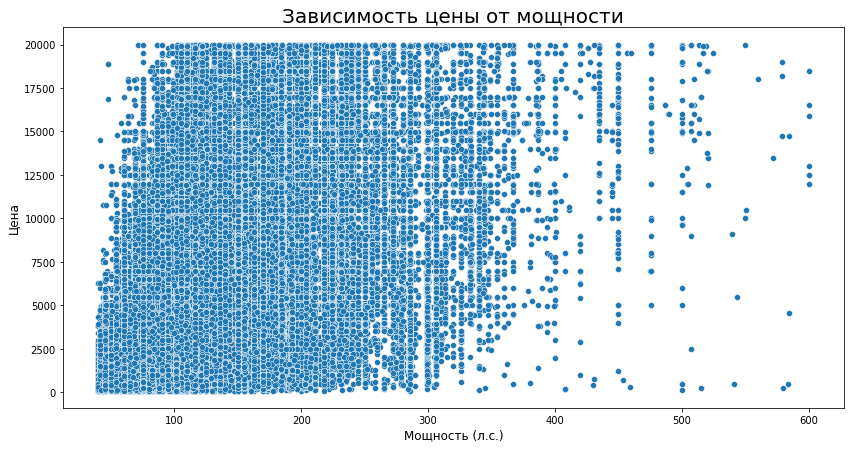

In [90]:
plt.figure(figsize=(14,7))
sns.scatterplot(data=clear_data, x='power', y='price')
plt.ylabel('Цена', fontsize=12)
plt.xlabel('Мощность (л.с.)', fontsize=12)
plt.title('Зависимость цены от мощности', fontsize=20)
plt.show()

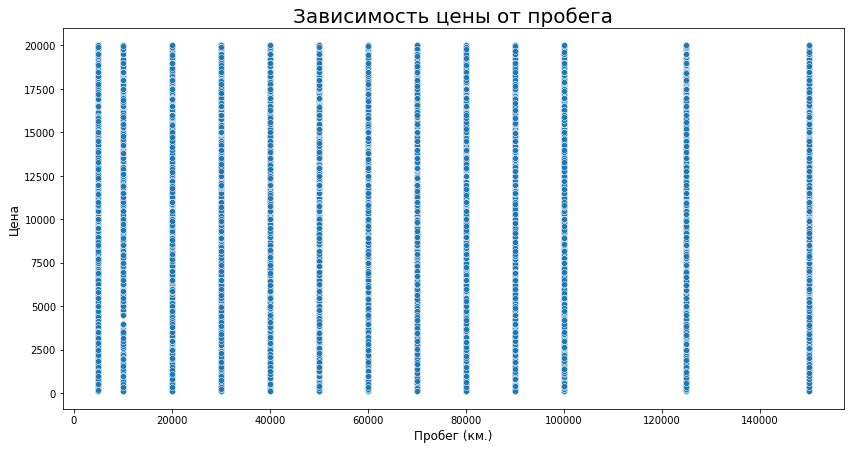

In [91]:
plt.figure(figsize=(14,7))
sns.scatterplot(data=clear_data, x='kilometer', y='price')
plt.ylabel('Цена', fontsize=12)
plt.xlabel('Пробег (км.)', fontsize=12)
plt.title('Зависимость цены от пробега', fontsize=20)
plt.show()

Линейная зависмость между целевым признаком и количественными отсутствует.

### Подготовка выборок для обучения

In [92]:
X = clear_data.drop(columns=['price']).copy()
y = clear_data['price'].copy()

In [93]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE
)

## Обучение моделей

In [94]:
ohe_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired']

In [96]:
ord_columns = ['registration_year', 'kilometer']

In [97]:
freq_columns = ['model', 'brand']

In [98]:
num_columns= ['power']

In [99]:
X_train_coded = X_train.copy()

In [100]:
X_test_coded = X_test.copy()

**Закодируем модель и марку автомобиля с помощью Frequency Encoding**

In [101]:
for column in freq_columns:
    frequency_train = X_train_coded[column].value_counts(normalize=True)
    X_train_coded[column] =  X_train_coded[column].map(frequency_train)
    frequency_test = X_test_coded[column].value_counts(normalize=True)
    X_test_coded[column] =  X_test_coded[column].map(frequency_test)


In [102]:
ohe_pipe = Pipeline(
    [
        (
                'simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
            ),
        (

            'ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)
        )
    ]
)

In [103]:
ord_pipe = Pipeline(
    [
        (
            'simpleImputer_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'ord', OrdinalEncoder(categories=[
                                              [1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994, \
                                               1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, \
                                               2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, \
                                               2015, 2016, 2017, 2018, 2019],
                                              [5000, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, \
                                               90000, 100000, 125000, 150000]
                                             ],
                                 handle_unknown='use_encoded_value', unknown_value=np.nan)
        ),
        (
            'simpleImputer_ord2', SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        )
    ]
)

In [104]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [105]:
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

In [106]:
bin_columns = ['vehicle_type', 'gearbox', 'fuel_type', 'repaired']

**Закодируем столбцы 'vehicle_type', 'gearbox', 'fuel_type', 'repaired' с помощью BinaryEncoder для работы с нелинейными моделями**

In [107]:
encoder = BinaryEncoder(cols=ohe_columns)

In [108]:
encoder.fit(X_train_coded)

BinaryEncoder(cols=['vehicle_type', 'gearbox', 'fuel_type', 'repaired'],
              mapping=[{'col': 'vehicle_type',
                        'mapping':     vehicle_type_0  vehicle_type_1  vehicle_type_2  vehicle_type_3
 1               0               0               0               1
 2               0               0               1               0
 3               0               0               1               1
 4               0               1               0               0
 5               0               1               0               1
 6               0               1               1               0
 7               0               1               1               1
 8               1               0               0               0
-1               0               0               0               0
-2               0               0               0               0},
                       {'col': 'gearbox',
                        'mapping':     gearbox_0  gearbox_1
 1          0          1
 2          1          0
-1          0          0
-2          0          0},
                       {'col': 'fuel_type',
                        'mapping':     fuel_type_0  fuel_type_1  fuel_type_2
 1            0            0            1
 2            0            1            0
 3            0            1            1
 4            1            0            0
 5            1            0            1
 6            1            1            0
-1            0            0            0
-2            0            0            0},
                       {'col': 'repaired',
                        'mapping':     repaired_0  repaired_1
 1           0           1
 2           1           0
-1           0           0
-2           0           0}])

In [109]:
X_train_coded_tree = encoder.transform(X_train_coded)

In [110]:
X_test_coded_tree = encoder.transform(X_test_coded)

In [111]:
data_preprocessor_tree = ColumnTransformer(
    [
        ('ord', ord_pipe, ord_columns),
        ('num', StandardScaler(), num_columns)
    ],
    remainder='passthrough'
)

In [112]:
pipe_final_tree = Pipeline(
    [
        ('preprocessor', data_preprocessor_tree),
        ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
    ]
)

Обучим модель с выбором между моделей регрессии.

In [113]:
param_distributions_lin = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [Ridge()], 
        'models__alpha': [1, 2, 3],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    } , 
    {
        'models': [Lasso()], 
        'models__alpha': [1, 2, 3],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }, 
    {
        'models': [ElasticNet()], 
        'models__alpha': [1, 2, 3], 
        'models__l1_ratio': [0, 0.25, 0.5, 0.75, 1.0],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [114]:
lin_randomized_search = RandomizedSearchCV(
    pipe_final,
    param_distributions = param_distributions_lin,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [115]:
lin_randomized_search.fit(X_train_coded, y_train)

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first',
                                                                                                              handle_unknown='ignore',
                                                                                                              sparse_output=False))]),
                                                                               ['vehicle_type',
                                                                                'gearbox',
                                                                                'fuel_type',
                                                                                'repaired']),
                                                                              ('ord',
                                                                               Pipeline...
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [Lasso()],
                                         'models__alpha': [1, 2, 3],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [ElasticNet()],
                                         'models__alpha': [1, 2, 3],
                                         'models__l1_ratio': [0, 0.25, 0.5,
                                                              0.75, 1.0],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='neg_root_mean_squared_error')

In [116]:
best_lin_model = lin_randomized_search.best_estimator_

In [117]:
lin_randomized_search.best_params_

{'preprocessor__num': 'passthrough', 'models__alpha': 1, 'models': Ridge()}

In [118]:
rmse_lin = -1*lin_randomized_search.best_score_.round()

In [119]:
rmse_lin

2752.0

In [120]:
start_lin = time.time()
best_lin_model.fit(X_train_coded, y_train)
lin_time = time.time() - start_lin

In [121]:
lin_time

0.5065712928771973

Обучение лучшей линейной модели длится 0.70 сек.

In [122]:
start_lin_pred = time.time()
y_pred_lin = best_lin_model.predict(X_train_coded)
lin_pred_time = time.time() - start_lin_pred

In [125]:
lin_pred_time

0.3975536823272705

Лучшая линейная модель делает предсказания за 0.44 сек. Показателем метрики 2752.

Обучим модель с помощью дерева принятия решений.

In [126]:
param_distributions_tree = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 11),
        'models__min_samples_split': range(2, 10),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [128]:
tree_randomized_search = RandomizedSearchCV(
    pipe_final_tree,
    param_distributions = param_distributions_tree,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)

In [129]:
tree_randomized_search.fit(X_train_coded_tree, y_train)

RandomizedSearchCV(error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ord',
                                                                               Pipeline(steps=[('simpleImputer_ord',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ord',
                                                                                                OrdinalEncoder(categories=[[1985,
                                                                                                                            1986,
                                                                                                                            1987,
                                                                                                                            1988,
                                                                                                                            1989,
                                                                                                                            1990,
                                                                                                                            1991,
                                                                                                                            1992,
                                                                                                                            1993,
                                                                                                                            1994,
                                                                                                                            1995,
                                                                                                                            1996,
                                                                                                                            1997,
                                                                                                                            1998,
                                                                                                                            1999,
                                                                                                                            2000,
                                                                                                                            2001,
                                                                                                                            2002,
                                                                                                                            200...
                                                                               StandardScaler(),
                                                                               ['power'])])),
                                             ('models',
                                              DecisionTreeRegressor(random_state=42))]),
                   n_jobs=-1,
                   param_distributions=[{'models': [DecisionTreeRegressor(random_state=42)],
                                         'models__max_depth': range(2, 11),
                                         'models__min_samples_split': range(2, 10),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42

In [130]:
tree_randomized_search.best_params_

{'preprocessor__num': StandardScaler(),
 'models__min_samples_split': 9,
 'models__max_depth': 10,
 'models': DecisionTreeRegressor(random_state=42)}

In [131]:
best_tree_model = tree_randomized_search.best_estimator_

In [132]:
rmse_tree = -1*tree_randomized_search.best_score_.round()

In [133]:
start_tree = time.time()
best_tree_model.fit(X_train_coded_tree, y_train)
tree_time = time.time() - start_tree

In [134]:
round(tree_time, 2)

0.64

Модель дерева решений обучается за 0.71 сек.

In [135]:
start_tree_pred = time.time()
y_pred_tree = best_tree_model.predict(X_train_coded_tree)
tree_pred_time = time.time() - start_tree_pred

In [136]:
rmse_tree

1885.0

In [137]:
round(tree_pred_time, 2)

0.08

Прогнозирование модели дерева решений происходит за 0.08 сек. со значением метрики 1885.

In [138]:
param_distributions_lgb= [
    {
        'models': [LGBMRegressor()],
        'models__max_depth': [10, 15],
        'models__min_data_in_leaf': [20, 30],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [139]:
lgb_randomized_search = RandomizedSearchCV(
    pipe_final_tree,
    param_distributions = param_distributions_lgb,
    scoring='neg_root_mean_squared_error',
    random_state=RANDOM_STATE,
    n_jobs=-1
)

In [140]:
lgb_randomized_search.fit(X_train_coded_tree, y_train)

[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min_data_in_leaf is set=30, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=30
[LightGBM] [Warning] min

RandomizedSearchCV(estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ord',
                                                                               Pipeline(steps=[('simpleImputer_ord',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ord',
                                                                                                OrdinalEncoder(categories=[[1985,
                                                                                                                            1986,
                                                                                                                            1987,
                                                                                                                            1988,
                                                                                                                            1989,
                                                                                                                            1990,
                                                                                                                            1991,
                                                                                                                            1992,
                                                                                                                            1993,
                                                                                                                            1994,
                                                                                                                            1995,
                                                                                                                            1996,
                                                                                                                            1997,
                                                                                                                            1998,
                                                                                                                            1999,
                                                                                                                            2000,
                                                                                                                            2001,
                                                                                                                            2002,
                                                                                                                            2003,
                                                                                                                            2004,
                                                                                                                            2005,
                                                                                                                            2006,
                                                                                                                            200...
                                                                                'kilometer']),
                                                                              ('num',
                                                                               StandardScaler(),
                                                                               ['power'])])),
                                          

In [141]:
lgb_randomized_search.best_params_

{'preprocessor__num': MinMaxScaler(),
 'models__min_data_in_leaf': 30,
 'models__max_depth': 15,
 'models': LGBMRegressor()}

In [142]:
lgb_best_model = lgb_randomized_search.best_estimator_

In [143]:
start_lgb = time.time()
lgb_best_model.fit(X_train_coded_tree, y_train)
lgb_time = time.time() - start_lgb

In [144]:
round(lgb_time, 2)

2.52

In [145]:
start_lgb_pred = time.time()
y_pred_lgb = lgb_best_model.predict(X_train_coded_tree)
lgb_pred_time = time.time() - start_lgb_pred

In [146]:
round(lgb_pred_time, 2)

1.4

In [147]:
rmse_lgb = -1*lgb_randomized_search.best_score_.round()

In [148]:
rmse_lgb

1648.0

С помощью лучшей модели LightGBM обучение происходит за 2.52 сек., предсказание за 1.51 сек., показатель метрики 1648.

## Анализ моделей

In [149]:
best_models = [lin_randomized_search.best_params_['models'], \
               tree_randomized_search.best_params_['models'], \
               lgb_randomized_search.best_params_['models']]

In [150]:
fit_time = [lin_time, tree_time, lgb_time]

In [151]:
predict_time = [lin_pred_time, tree_pred_time, lgb_pred_time]

In [152]:
models_score = [rmse_lin, rmse_tree, rmse_lgb]

In [153]:
models_data = pd.DataFrame(list(zip(best_models, fit_time, predict_time, models_score)), \
                           columns =['model', 'fit_time', 'prediction_time', 'rmse'])

In [154]:
models_data.sort_values('rmse')

,model,fit_time,prediction_time,rmse
2,LGBMRegressor(),2.515845,1.395008,1648.0
1,DecisionTreeRegressor(random_state=42),0.636335,0.084294,1885.0
0,Ridge(),0.506571,0.397554,2752.0


Самые точные предсказания дает модель LGBMRegressor. Однако время ее обработки самое длинное.  При этом на существующей выборке ожидание в несколько секунд не является критичным. Считаю, что в данном случае заказчику следует остановить свой выбор на ней. В случае большого роста количества данных и наличии больших задержек при прогнозировании имеет смысл перейти на модель DecisionTreeRegressor.

In [155]:
y_pred_test = lgb_best_model.predict(X_test_coded_tree)

In [156]:
root_mean_squared_error(y_test, y_pred_test).round()

1747.0

На тестовых данных модель показала значение метрики равное 1747.

## Общий вывод

В ходе данной работы производилась разработка модели машинного обучения для прогнозирования стоимости автомобиля на основе его характеристик. Модель требуется сервису по продаже автомобилей с пробегом «Не бит, не крашен» для приложения, чтобы привлечь новых клиентов.

Заказчиком были предоставлены следующие данные с характеристиками автомобилей:
- дата скачивания анкеты из базы
- тип автомобильного кузова
- год регистрации автомобиля
- тип коробки передач
- мощность (л. с.)
- модель автомобиля
- пробег (км)
- месяц регистрации автомобиля
- тип топлива
- марка автомобиля
- была машина в ремонте или нет
- дата создания анкеты
- количество фотографий автомобиля
- почтовый индекс владельца анкеты (пользователя)
- дата последней активности пользователя

В ходе предобработки данных столбцы с датой скачивания, датой создания анкеты, дата последней активности, месяцем регистрации, почтовым индексом, количеством фотографий были удалены как неинформативные.

Записи с пропусками в данных о модели автомобиля были удалены т.к. это является одним из ключевых параметров.

Пропуски в типе транспортного средства, коробки передач и типе топлива были заполнены модой по бренду и модели.
Пропуски в столбце с информацией о ремонте заменены на значение "no".
Значения типа топлива "gasoline" заменено на "petrol" т.к. эти термины обозначают одно и то же.

При проведени исследовательского анализа проведены следующие изменения данных:
- удалены записи со значениями стоимости менее 100 и более 18500 как аномальные
- удалены записи с годом регистрации менее 1985 и более 2019
- нулевое значение мощности заменено на модальное значение по марке и модели
- удалены записи с мощнотью менее 40 и более 300 л.с.

В ходе корреляционного анализа установлено, что среди признаков наибольшая зависимость с ценой наблюдается у года регистрации, модели и мощности.
Линейнная зависимость между признаками и целевой переменной отсутствует.

Было построено три типа моделей машинного обуччения. Первый тип - модели линейной регрессии. Среди них лучшей остальных показала результаты модель Ridge() с параметрами 'preprocessor__num': 'passthrough', 'models__alpha': 1.
Второй тип модели - дерево принятия решения. Парматеры лучшей модели 'preprocessor__num': StandardScaler(), 'models__min_samples_split': 9, 'models__max_depth': 10.
Третий тип - LightGBM. Лучшие показатели с параметрами 'preprocessor__num': 'passthrough', 'models__min_data_in_leaf': 30, 'models__max_depth': 15.

При оценке качества пргнозирования моделей исползовалась метрика RMSE. По данному критерию лучше остальных себя показала модель LightGBM - 1563. При этом по временным характеристикам она оказалась хуже остальных. Однако т.к. на предоставленных данных время измеряется несколькими секундами заказчику рекомендовано использовать в первую очередь ее. При росте количества данных и в случае значительного увеличения времени обработки, рекомендовано перейти на модель DecisionTreeRegressor. У нее немного хуже точность прогноза RMSE = 1756, но скорость выполнения прогноза быстрее в четыре раза. Модель линейной регрессии заказчику не подходит т.к. у нее RMSE больше допустимого порогового значения.